# Classify ALS status using AFQ-Insight

In [1]:
import afqinsight as afqi
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import pandas as pd
import palettable
import pickle

from matplotlib.colors import to_hex
from mpl_toolkits.mplot3d import Axes3D

from bokeh.io import output_notebook, reset_output, export_png
from bokeh.embed import file_html
from bokeh.layouts import row, column, widgetbox
from bokeh.models import BoxSelectTool, HoverTool, Legend, Title, Range1d, CustomJS, ColorBar
from bokeh.models.tickers import FixedTicker
from bokeh.models.mappers import LinearColorMapper
from bokeh.palettes import Spectral10, RdBu, Category10
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.resources import CDN
from bokeh.transform import factor_cmap
from bokeh.models import BoxAnnotation, Label

from sklearn.decomposition import PCA
import seaborn as sns

%matplotlib notebook

In [2]:
output_notebook()

Loading BokehJS ...

## Load the data

In [3]:
afq_data = afqi.load_afq_data(
    '../data/raw/als_data',
    target_cols=['class'],
    binary_positives={'class': 'ALS'},
    scale_x=False
)

x, y, groups, columns, bias_index = (
    afq_data.x,
    afq_data.y['class'],
    afq_data.groups,
    afq_data.columns,
    afq_data.bias_index
)

/Users/richford/miniconda3/envs/insight-dev/lib/python3.6/site-packages/pandas/core/indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [4]:
len(y)

48

In [5]:
label_sets = afqi.multicol2sets(columns, tract_symmetry=True)
select_labels = [["fa"], ["md"]]
x_md_fa = afqi.select_groups(np.delete(x, bias_index, axis=1), select_labels, label_sets)

In [6]:
x_md_fa = np.hstack([x_md_fa, x[:, bias_index][:, np.newaxis]])

## Find the optimal feature coefficients $\widehat{\beta}$

We search for the optimal coefficients using two different classification scores: accuracy and ROC AUC.

In [7]:
# hp_cv_res_acc_reload = afqi.fit_hyperparams_cv(
#     x, y, groups, bias_index=bias_index,
#     n_splits=10, n_repeats=5,
#     max_evals_per_cv=5,
#     score='accuracy',
#     trials_pickle_dir='./trials_classification/new_trials_for_poster',
#     verbose=1, random_state=42, clf_threshold=0.5
# )

In [8]:
# hp_cv_res_acc_reload_add = afqi.fit_hyperparams_cv(
#     x, y, groups, bias_index=bias_index,
#     n_splits=10, n_repeats=5,
#     max_evals_per_cv=10,
#     score='accuracy',
#     trials_pickle_dir='./trials_classification/new_trials_for_poster',
#     verbose=1, random_state=42, clf_threshold=0.5
# )

In [9]:
import pickle

In [10]:
# with open("poster_hp_cv_res_acc_reload.pkl", "wb") as fp:
#     pickle.dump(hp_cv_res_acc_reload, fp)

In [11]:
# with open("poster_hp_cv_res_acc_reload_add.pkl", "wb") as fp:
#     pickle.dump(hp_cv_res_acc_reload_add, fp)

In [12]:
with open("poster_hp_cv_res_acc_reload.pkl", "rb") as fp:
    hp_cv_res_acc_reload = pickle.load(fp)

with open("poster_hp_cv_res_acc_reload_add.pkl", "rb") as fp:
    hp_cv_res_acc_reload_add = pickle.load(fp)

In [13]:
# hp_cv_res_acc_md_fa = afqi.fit_hyperparams_cv(
#     x_md_fa, y, groups[:40], bias_index=4000,
#     n_splits=10, n_repeats=3,
#     max_evals_per_cv=80,
#     score='accuracy',
#     trials_pickle_dir='./trials_classification/cv3x10_v2_rs42_scaled_accuracy_md_fa_only',
#     verbose=1, random_state=42, clf_threshold=0.5
# )

In [14]:
# hp_cv_res_auc = afqi.fit_hyperparams_cv(
#     x, y, groups, bias_index=bias_index,
#     n_splits=10, n_repeats=3,
#     max_evals_per_cv=10,
#     score='roc_auc',
#     trials_pickle_dir='./trials_classification/cv3x10_v2_rs42_scaled_auc_new',
#     verbose=1, random_state=42, clf_threshold=0.5
# )

In [15]:
# hp_cv_res_auc_md_fa = afqi.fit_hyperparams_cv(
#     x_md_fa, y, groups[:40], bias_index=4000,
#     n_splits=10, n_repeats=3,
#     max_evals_per_cv=10,
#     score='roc_auc',
#     trials_pickle_dir='./trials_classification/cv3x10_v2_rs42_scaled_auc_md_fa_only_new',
#     verbose=1, random_state=42, clf_threshold=0.5
# )

In [16]:
# hp_cv_res_avgprec = afqi.fit_hyperparams_cv(
#     x, y, groups, bias_index=bias_index,
#     n_splits=10, n_repeats=3,
#     max_evals_per_cv=10,
#     score='avg_precision',
#     trials_pickle_dir='./trials_classification/cv3x10_v2_rs42_scaled_avgprec_new',
#     verbose=1, random_state=42, clf_threshold=0.5
# )

In [17]:
# hp_cv_res_avgprec_md_fa = afqi.fit_hyperparams_cv(
#     x_md_fa, y, groups[:40], bias_index=4000,
#     n_splits=10, n_repeats=3,
#     max_evals_per_cv=10,
#     score='avg_precision',
#     trials_pickle_dir='./trials_classification/cv3x10_v2_rs42_scaled_avgprec_md_fa_only_new',
#     verbose=1, random_state=42, clf_threshold=0.5
# )

In [18]:
def print_results_summary(hp_cv_results):
    template = '{stat:15s} {mean:7.5g} ({var:7.5g})'
    test = [r["test"] for r in hp_cv_results]
    train = [r["train"] for r in hp_cv_results]
    test_acc = [t["accuracy"] for t in test]
    test_auc = [t["auc"] for t in test]
    test_aps = [t["avg_precision"] for t in test]
    train_acc = [t["accuracy"] for t in train]
    train_auc = [t["auc"] for t in train]
    train_aps = [t["avg_precision"] for t in train]

    print('Statistic         mean   (variance)')
    print('--------------  ------- ------------')
    print(template.format(stat='test accuracy', mean=np.mean(test_acc), var=np.var(test_acc)))
    print(template.format(stat='test AUC', mean=np.mean(test_auc), var=np.var(test_auc)))
    print(template.format(stat='test avg prec', mean=np.mean(test_aps), var=np.var(test_aps)))
    print(template.format(stat='train accuracy', mean=np.mean(train_acc), var=np.var(train_acc)))
    print(template.format(stat='train AUC', mean=np.mean(train_auc), var=np.var(train_auc)))
    print(template.format(stat='train avg prec', mean=np.mean(train_aps), var=np.var(train_aps)))

In [19]:
print_results_summary(hp_cv_res_acc_reload)

Statistic         mean   (variance)
--------------  ------- ------------
test accuracy     0.725 (0.050903)
test AUC        0.80889 (0.054063)
test avg prec   0.87456 (0.021622)
train accuracy  0.99084 (0.0010409)
train AUC       0.99705 (0.0001491)
train avg prec  0.99684 (0.00018303)


In [20]:
print_results_summary(hp_cv_res_acc_reload_add)

Statistic         mean   (variance)
--------------  ------- ------------
test accuracy   0.74667 (0.039989)
test AUC        0.82111 (0.042937)
test avg prec   0.87967 (0.020481)
train accuracy  0.99857 ( 0.0001)
train AUC       0.99982 (1.6125e-06)
train avg prec  0.99983 (1.4061e-06)


In [21]:
test_set_y_hat = pd.concat([
    pd.Series(data=afqi.insight._sigmoid(cv["test"]["x"].dot(cv["beta_hat"])),
              index=cv["test"]["y"].index,
              name='yhat')
    for cv in hp_cv_res_acc_reload_add
]).groupby('subjectID').mean()

In [22]:
test_probs = {
    idx: pd.Series(
        data=afqi.insight._sigmoid(cv["test"]["x"].dot(cv["beta_hat"])),
        index=cv["test"]["y"].index,
        name='yhat'
    )
    for idx, cv in enumerate(hp_cv_res_acc_reload_add)
}

In [23]:
from sklearn.metrics import accuracy_score, average_precision_score, f1_score
from sklearn.metrics import roc_auc_score, r2_score, mean_squared_error

In [24]:
df_ytest = {idx: pd.DataFrame(test_probs[idx]).merge(pd.DataFrame(y), left_index=True, right_index=True, how="left")
            for idx in range(50)}
acc_scores = [accuracy_score(_df["class"].values, _df["yhat"].values > 0.5) for _df in df_ytest.values()]

In [25]:
def mean_over_combinations(results):
    length = len(results)
    mean_results = {}
    for r in range(1, length + 1):
        mean_results[r] = [
            np.mean([res["yhat"].values for res in comb], axis=0)
            for comb in itertools.combinations(results, r=r)
        ]
        
    return mean_results

In [26]:
def accuracy_over_combinations(results):
    mean_results = mean_over_combinations(results)
    mean_accuracies = []
    for r in mean_results.keys():
        mean_accuracies += [
            {
                "n_repeats": r,
                "accuracy": accuracy_score(results[0]["class"].values, res > 0.5)
            } for res in mean_results[r]
        ]
        
    return pd.DataFrame(mean_accuracies)

def auc_over_combinations(results):
    mean_results = mean_over_combinations(results)
    mean_auc = []
    for r in mean_results.keys():
        mean_auc += [
            {
                "n_repeats": r,
                "auc": roc_auc_score(results[0]["class"].values, res)
            } for res in mean_results[r]
        ]
        
    return pd.DataFrame(mean_auc)

In [27]:
r0 = pd.concat([df_ytest[i] for i in range(10)]).sort_index()
r1 = pd.concat([df_ytest[i] for i in range(10, 20)]).sort_index()
r2 = pd.concat([df_ytest[i] for i in range(20, 30)]).sort_index()
r3 = pd.concat([df_ytest[i] for i in range(30, 40)]).sort_index()
r4 = pd.concat([df_ytest[i] for i in range(40, 50)]).sort_index()

In [28]:
df_accuracies = accuracy_over_combinations([r0, r1, r2, r3, r4])
df_auc = auc_over_combinations([r0, r1, r2, r3, r4])

In [29]:
print(df_accuracies[df_accuracies["n_repeats"] == 4]["accuracy"].mean())
print(df_accuracies[df_accuracies["n_repeats"] == 4]["accuracy"].std())

0.9333333333333332
0.01743041721945994


In [30]:
print(df_auc[df_auc["n_repeats"] == 4]["auc"].mean())
print(df_auc[df_auc["n_repeats"] == 4]["auc"].std())

0.992013888888889
0.004690713918786902


In [31]:
import seaborn as sns

%matplotlib inline

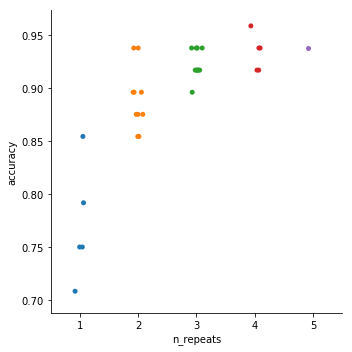

In [32]:
sns.catplot(x="n_repeats", y="accuracy", data=df_accuracies)

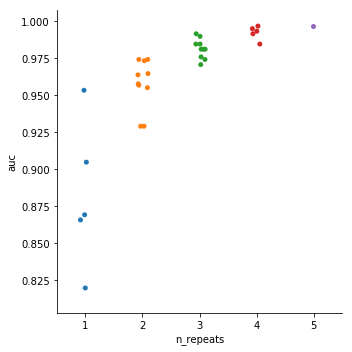

In [33]:
sns.catplot(x="n_repeats", y="auc", data=df_auc)

In [34]:
y_y_hat = pd.concat([y, test_set_y_hat], axis='columns', sort=True)
y_y_hat['index'] = np.arange(len(y), dtype=np.int32)
y_y_hat.sort_values(['class', 'yhat'], inplace=True)
y_y_hat['sorted_index'] = np.arange(len(y_y_hat))

In [35]:
import beeswarm as bs

In [36]:
list_of_preds = [y_y_hat.loc[y_y_hat['class'] == 0, 'yhat'].values, y_y_hat.loc[y_y_hat['class'] == 1, 'yhat'].values]

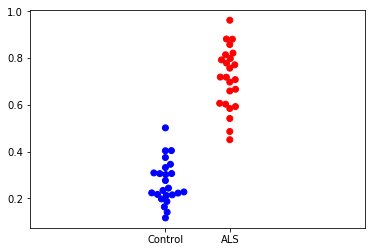

In [37]:
df_bs, ax = bs.beeswarm(list_of_preds, s=23, method='swarm', positions=[0, 0.05], labels=['Control', 'ALS'], col=['blue', 'red'])

In [38]:
df_bs.rename(columns=lambda x: 'yhat' if x == 'yorig' else x, inplace=True)
df_bs.columns
df_bs.sort_values(['xorig', 'yhat'], inplace=True)
df_bs['sorted_index'] = np.arange(len(df_bs))

In [39]:
df_yhat = y_y_hat.join(df_bs, on='sorted_index', rsuffix='_bs')
df_yhat.drop(['sorted_index', 'sorted_index_bs', 'xorig', 'yhat_bs'], axis='columns', inplace=True)
df_yhat['predicted_class_text'] = df_yhat['yhat'].map(lambda x: 'Predicted ALS' if x > 0.5 else 'Predicted Control')
df_yhat.loc[df_yhat['yhat'] <= 0.5, 'color'] = 'blue'
df_yhat.loc[df_yhat['yhat'] > 0.5, 'color'] = 'red'
df_yhat.head()

,class,yhat,index,xnew,ynew,color,predicted_class_text
subjectID,,,,,,,
subject_034,0,0.116153,34,0.000000,0.116153,blue,Predicted Control
subject_040,0,0.140697,40,0.001342,0.140697,blue,Predicted Control
subject_044,0,0.163399,44,-0.000819,0.163399,blue,Predicted Control
subject_026,0,0.186608,26,0.001157,0.186608,blue,Predicted Control
subject_042,0,0.197302,42,-0.003074,0.197302,blue,Predicted Control


In [43]:
width=1800
height=900
p = figure(plot_width=width, plot_height=height, toolbar_location=None,
           tools="save", x_range=(-0.0188, 0.065))
p.y_range = Range1d(0, 1)

source = ColumnDataSource(data=df_yhat)

c0 = p.circle(source=source, x='xnew', y='ynew',
              size=40, legend='predicted_class_text', color='color')

l = p.line(x=[-0.0188, 0.065], y=[0.5, 0.5], line_width=10, color='black', line_dash='dashed')
hover = HoverTool(
    tooltips=[("Subject", "@index"),
              ("P(ALS)", "@yhat")],
    renderers=[c0]
)
hover.point_policy = 'snap_to_data'
hover.line_policy = 'nearest'

p.add_tools(hover)

legend = p.legend[0]
p.add_layout(legend, 'right')

p.xaxis.axis_label = "Class"
p.xaxis.ticker = FixedTicker(ticks=[0, 0.05])
p.xaxis.major_label_overrides = {0: 'Control', 0.05: 'ALS'}
p.xaxis.major_label_text_font_size = "44pt"
p.xaxis.minor_tick_line_color = None  # turn off x-axis minor ticks
#p.xaxis.major_label_text_font_size = '0pt'  # turn off x-axis tick labels
p.yaxis.axis_label = "Classification Probability"
p.title.text_font_size = "46pt"
p.xaxis.axis_label_text_font_size = "46pt"
p.yaxis.axis_label_text_font_size = "46pt"
p.yaxis.major_label_text_font_size = "44pt"

p.legend.label_text_font_size = '44pt'
p.legend.glyph_height = 135
p.legend.glyph_width = 135

output_html = "../docs/img/bokeh_plots/classification_probs.html"
if output_html is not None:
    html = file_html(p, CDN, "my plot")
    with open(op.abspath(output_html), 'w') as fp:
        fp.write(html)

# export_png(p, filename="classification_probs.png")

# show(p)

Using the hover tool on the chart above, we can see that subjects 05, 16, 19, 32, 35, 36 are all hard to classify (i.e. they are closer to the classification threshold of 0.5). We should fire up the AFQ browser and look at how these subjects compare to the rest of the subjects in their group.

Here are links to a running instance of AFQ-Browser with the hard to classify subjects:
- [False negatives](https://yeatmanlab.github.io/Sarica_2017/?table[prevSort][count]=2&table[prevSort][order]=ascending&table[prevSort][key]=&table[sort][count]=2&table[sort][order]=ascending&table[sort][key]=class&table[selectedRows][subject_005]=true&table[selectedRows][subject_016]=true&table[selectedRows][subject_019]=true&table[selectedRows][subject_030]=false&table[selectedRows][subject_032]=false&table[selectedRows][subject_035]=false&table[selectedRows][subject_036]=false&plots[checkboxes][right-corticospinal]=true&plots[zoom][rd][scale]=1&plots[zoom][rd][translate][0]=-3&plots[zoom][rd][translate][1]=-21&plots[zoom][fa][scale]=2.1140360811227614&plots[zoom][fa][translate][0]=-27.244995845837778&plots[zoom][fa][translate][1]=-106.10468474511174&plots[plotKey]=fa&plots[errorType]=stderr&plots[lineOpacity]=0.0)
- [False positives](https://yeatmanlab.github.io/Sarica_2017/?table[prevSort][count]=2&table[prevSort][order]=ascending&table[prevSort][key]=&table[sort][count]=2&table[sort][order]=ascending&table[sort][key]=class&table[selectedRows][subject_005]=false&table[selectedRows][subject_007]=false&table[selectedRows][subject_016]=false&table[selectedRows][subject_019]=false&table[selectedRows][subject_032]=true&table[selectedRows][subject_035]=true&table[selectedRows][subject_036]=true&plots[checkboxes][right-corticospinal]=true&plots[zoom][rd][scale]=1&plots[zoom][rd][translate][0]=-3&plots[zoom][rd][translate][1]=-21&plots[zoom][fa][scale]=2.1140360811227614&plots[zoom][fa][translate][0]=-27.244995845837778&plots[zoom][fa][translate][1]=-106.10468474511174&plots[plotKey]=fa&plots[errorType]=stderr&plots[lineOpacity]=0.0)

# Feature Importance

Let's sort the features by their importance

In [44]:
columns_md_fa = columns.drop(['ad', 'cl', 'curvature', 'rd', 'torsion', 'volume'], level=0)
columns_md_fa = columns_md_fa.remove_unused_levels()

In [45]:
feature_dicts = afqi.multicol2dicts(columns, tract_symmetry=False)
mean_beta = np.mean(np.array([np.delete(res["beta_hat"], bias_index) for res in hp_cv_res_acc_reload_add]),
                    axis=0)

var_beta = np.std(np.array([np.delete(res["beta_hat"], bias_index) for res in hp_cv_res_acc_reload_add]),
                    axis=0)

sorted_features = afqi.sort_features(feature_dicts, mean_beta)

It's nice to see the top few features in a sorted list, but let's plot the features to get a feel for their distributions

In [46]:
beta_hats = afqi.beta_hat_by_groups(mean_beta, columns=columns, drop_zeros=True)
beta_hats_var = afqi.beta_hat_by_groups(var_beta, columns=columns, drop_zeros=True)

First let's plot the coefficients themselves

In [47]:
unfolded_beta = afqi.transform.unfold_beta_hat_by_metrics(
    beta_hat=mean_beta,
    columns=columns
)

unfolded_beta_std = afqi.transform.unfold_beta_hat_by_metrics(
    beta_hat=var_beta,
    columns=columns
)

In [48]:
unfolded_beta_with_err = {
    'fa': unfolded_beta['fa'],
    'fa_hi': unfolded_beta['fa'] + unfolded_beta_std['fa'],
    'fa_lo': unfolded_beta['fa'] - unfolded_beta_std['fa'],
    'md': unfolded_beta['md'],
    'md_hi': unfolded_beta['md'] + unfolded_beta_std['md'],
    'md_lo': unfolded_beta['md'] - unfolded_beta_std['md'],
}

In [49]:
# width = 1150
# height = 700
# output_html = None

# p = figure(plot_width=width, plot_height=height, toolbar_location='above',
#               tools="save")
# p.title.text = 'Feature weights in the "unfolded" brain'

# len_alltracts = len(unfolded_beta[list(unfolded_beta.keys())[0]])
# n_tracts = len(afqi.utils.canonical_tract_names)
# n_nodes = len_alltracts / n_tracts
# ticks = np.arange(0, len_alltracts, n_nodes)

# p.xaxis.ticker = FixedTicker(ticks=[ticks[4] + n_nodes/2, ticks[-4] - n_nodes/2],
#                              minor_ticks=[ticks[0], ticks[9], ticks[11], ticks[-1] + n_nodes])
# p.xaxis.major_label_overrides = {int(ticks[4] + n_nodes/2): 'Left Hemisphere',
#                                  int(ticks[-4] - n_nodes/2): 'Right Hemisphere'}

# p.xaxis.minor_tick_line_color = None  # turn off x-axis minor ticks
# p.xaxis.major_tick_line_color = None  # turn off x-axis major ticks

# p.xaxis.major_label_text_font_size = '14pt'  # turn off x-axis tick labels

# p.x_range = Range1d(0, len_alltracts)
# p.xgrid.grid_line_color = None

# tract_colors = np.copy(palettable.tableau.Tableau_20.hex_colors).tolist()
# tract_colors = (tract_colors[1:-2:2]
#                 + tract_colors[-2:]
#                 + tract_colors[-3::-2])

# for i, color in enumerate(tract_colors):
#     p.add_layout(BoxAnnotation(
#         left=ticks[i], right=ticks[i] + n_nodes,
#         fill_color=color, fill_alpha=0.15
#     ))

#     p.add_layout(Label(
#         x=ticks[i] + n_nodes / 2,
#         y=10,
#         x_units='data',
#         y_units='screen',
#         text=afqi.utils.canonical_tract_names[i].replace('Left ', '').replace('Right ',''),
#         render_mode='canvas',
#         border_line_alpha=0.0,
#         background_fill_alpha=0.0,
#         angle=np.pi / 2,
#         text_align='left',
#         text_baseline='middle'
#     ))

# p.add_layout(BoxAnnotation(
#     left=ticks[0], right=ticks[9],
#     fill_color=None, fill_alpha=0.0,
#     line_color="black", line_width=4
# ))
# p.add_layout(BoxAnnotation(
#     left=ticks[9], right=ticks[11],
#     fill_color=None, fill_alpha=0.0,
#     line_color="black", line_width=4
# ))
# p.add_layout(BoxAnnotation(
#     left=ticks[11], right=ticks[-1] + n_nodes,
#     fill_color=None, fill_alpha=0.0,
#     line_color="black", line_width=4
# ))
    
# unfolded_beta_with_err['x'] = np.arange(len_alltracts)
# source = ColumnDataSource(data=unfolded_beta_with_err)
# del unfolded_beta_with_err['x']

# lines = {}
# for name, color in zip(
#         unfolded_beta.keys(),
#         Category10[max(len(list(unfolded_beta.keys())),
#                        min(list(Category10.keys())))]
# ):
#     lines[name] = p.line(
#         x='x', y=name, source=source, name=name,
#         line_width=3, color=color
#     )
#     lines[name + '_hi'] = p.line(
#         x='x', y=name + '_hi', source=source, name=name,
#         line_width=1, color=color
#     )
#     lines[name + '_lo'] = p.line(
#         x='x', y=name + '_lo', source=source, name=name,
#         line_width=1, color=color
#     )

# p.add_tools(HoverTool(
#     show_arrow=False,
#     line_policy='interp',
#     tooltips=[
#         ('metric', '$name'),
#         ('beta', '$y'),
#     ],
#     point_policy='snap_to_data',
#     renderers=list(lines.values())
# ))

# legend = Legend(items=[
#     (name, [renderer]) for name, renderer in lines.items()
# ], location=(0, 70))

# p.add_layout(
#     Title(text='Click on legend entries to hide/show lines',
#           align="left"), 'right'
# )
# p.add_layout(legend, 'right')
# p.legend.click_policy = 'hide'

# p.title.text_font_size = "18pt"
# p.yaxis.axis_label = "β"
# p.yaxis.axis_label_text_font_size = "18pt"

# # output_html = "../docs/img/bokeh_plots/classification_unfolded_beta.html"
# # if output_html is not None:
# #     html = file_html(p, CDN, "my plot")
# #     with open(op.abspath(output_html), 'w') as fp:
# #         fp.write(html)

# show(p)

In [77]:
from dipy.viz import window, actor, panel
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
from dipy.tracking.streamline import transform_streamlines
from dipy.viz import colormap
from dipy.viz import ui

import json

In [51]:
with open("../data/raw/core_streamlines.json") as fp:
    cores = json.load(fp)

In [52]:
# import deepdish as dd

In [53]:
# dd.io.save("als_classify_betas.h5", beta_hats)

In [54]:
encode_variance = False

In [91]:
renderer = window.Renderer()

renderer.background((1, 1, 1))
metric = "fa"
colors = np.concatenate([beta_hats[bn][metric] for bn in beta_hats.keys()])
bundle_names = beta_hats.keys()
bundles = [np.array(cores[bn]["coreFiber"]) for bn in bundle_names]
cmap = actor.create_colormap(colors, name="BuPu_r")

if encode_variance:
    alpha = np.concatenate([beta_hats_var[bn][metric] for bn in beta_hats.keys()])[:, np.newaxis]
    alpha = np.interp(alpha, (alpha.min(), alpha.max()), (1, 0))
    cmap = np.hstack([cmap, alpha])

stream_actor = actor.line(
    lines=bundles,
    colors=cmap,
    linewidth=20,
    spline_subdiv=5000,
    fake_tube=False,
)

ctable = colormap.colormap_lookup_table(scale_range=(np.min(colors), -np.min(colors)))
ctable.SetNumberOfTableValues(2000)
cmap_sorted = actor.create_colormap(np.sort(colors), name="BuPu_r")
for idx, col in enumerate(cmap_sorted):
    ctable.SetTableValue(idx, col[0], col[1], col[2], 1.0)

ctable.SetTableRange(np.min(colors), np.max(colors))
cbar = actor.scalar_bar(ctable)
tprop = cbar.GetLabelTextProperty()
tprop.SetColor(0.0, 0.0, 0.0)
cbar.SetLabelTextProperty(tprop)

renderer.set_camera(
    position=(8.90, 291.48, 153.57),
    focal_point=(3.23, -23.03, 18.32),
    view_up=(0.00, -0.40, 0.92)
)

renderer.add(stream_actor)
vtk_axes = actor.axes(scale=(30, 30, 30))
vtk_axes.SetPosition((0, 0, -55))
renderer.add(vtk_axes)

# panel_actor = ui.Panel2D(size=(100, 100))
# panel_actor.add_element(element=vtk_axes, coords=(0.2, 0.2))
# renderer.add(panel_actor)

cbar.SetPosition((0.82, 0.3))
renderer.add(cbar)
window.show(renderer, size=(1800, 1800))
# window.record(renderer, out_path='classification_beta_bupu.png', size=(1800, 1800))

In [96]:
cbar.GetPosition()

(0.82, 0.1)

In [71]:
renderer.camera_info()

# Active Camera
   Position (8.90, 291.48, 153.57)
   Focal Point (3.23, -23.03, 18.32)
   View Up (0.00, -0.40, 0.92)


In [100]:
subjects = pd.read_csv("../data/raw/als_data/subjects.csv")
nodes = pd.read_csv("../data/raw/als_data/nodes.csv")
merged = pd.merge(nodes, subjects, on="subjectID")
stats = nodes.columns.drop(["subjectID", "tractID", "nodeID"])
stat = merged[["nodeID", "tractID", "fa", "class"]]

In [101]:
tract_names = ["Right Corticospinal",]
tract_stats = {}
for tid in tract_names:
    tract_stats[tid] = stat[stat["tractID"] == tid].drop("tractID", axis="columns")

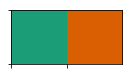

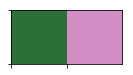

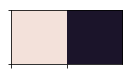

In [102]:
cat2 = ["#1b9e77","#d95f02"]
sns.palplot(sns.color_palette(cat2))
sns.palplot(sns.color_palette("cubehelix", 2))
sns.palplot(sns.cubehelix_palette(2, dark=0.1, light=0.9))

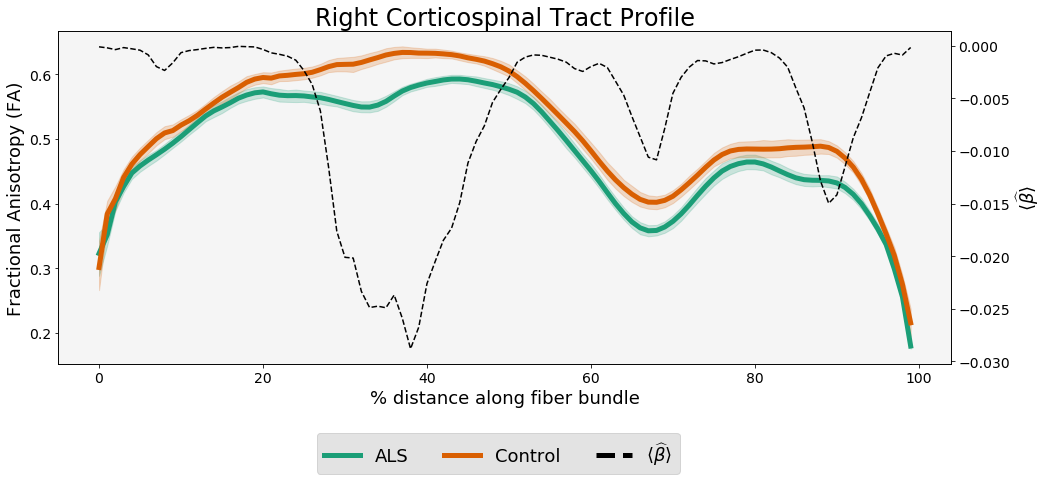

In [103]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 7))
ticksize = 14
labelsize = 18
titlesize = 24
bgcolor = "whitesmoke"

df_stat = tract_stats[tract_names[0]]
title = tract_names[0]

sns.lineplot(
    x="nodeID", y="fa", hue="class", data=df_stat,
    ci=68.2, palette=cat2,
    ax=ax,
    linewidth=5.0
)

_ = ax.set_xlabel("% distance along fiber bundle", fontsize=labelsize)
_ = ax.set_ylabel("Fractional Anisotropy (FA)", fontsize=labelsize)
_ = ax.tick_params(axis='both', which='major', labelsize=ticksize)
_ = ax.set_facecolor(bgcolor)
_ = ax.get_legend().remove()
    
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

ax2 = ax.twinx()
beta_line = ax2.plot(beta_hats[title]["fa"], linestyle="--", color="black")
_ = ax2.set_ylabel(r"$\langle \widehat{\beta} \rangle$", fontsize=labelsize)
_ = ax2.tick_params(axis='both', which='major', labelsize=ticksize)

_ = ax.set_title(tract_names[0] + " Tract Profile", fontsize=titlesize)

handles, labels = ax.get_legend_handles_labels()
handles = handles[1:] + beta_line
labels = ["ALS",
          "Control",
          r"$\langle \widehat{\beta} \rangle$"]

fig.subplots_adjust(bottom=0.22, wspace=0.3)

leg = plt.figlegend(
    handles, labels,
    fontsize=labelsize, facecolor="gainsboro",
    bbox_to_anchor=(0.4325, -0.01),
    loc="lower center",
    ncol=6
)

# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)

fig.savefig("classification_tract_profiles.pdf", bbox_inches="tight")

In [ ]:
np.mean([np.count_nonzero(cv["beta_hat"]) / len(cv["beta_hat"]) for cv in hp_cv_res_acc_reload_add])